In [15]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
import numpy as np
import PIL.Image
import time
#import functools
import os
import glob

In [10]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [17]:


inpFile = '{}/{}'.format(os.getcwd(), 'GSFC_20171208_Archive_e000816_small.jpg')
fileList = glob.glob(inpFile)
fileList[0]


'E:\\04. TalentPlatform\\Github\\TalentPlatform-Python\\src\\subject\\CycleGAN/GSFC_20171208_Archive_e000816_small.jpg'

In [44]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg',
# 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# style_path = tf.keras.utils.get_file('kandinsky5.jpg',
# 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

inpFile = '{}/{}'.format(os.getcwd(), 'GSFC_20171208_Archive_e000816_small.jpg')
fileList = glob.glob(inpFile)
content_path = fileList[0]

inpFile = '{}/{}'.format(os.getcwd(), '20011_안견_몽유도원도.jpg')
# inpFile = '{}/{}'.format(os.getcwd(), '20290_김홍도_비선검무.jpg')
fileList = glob.glob(inpFile)
style_path = fileList[0]

In [45]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [46]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 512, 512, 3)
(1, 185, 512, 3)


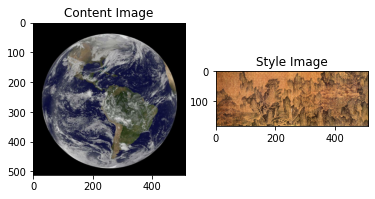

In [47]:
content_image = load_img(content_path)
style_image = load_img(style_path)
print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [48]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

(1, 1000)


[('bubble', 0.7221792),
 ('jellyfish', 0.1391533),
 ('chambered_nautilus', 0.029427376),
 ('gong', 0.015487156),
 ('Petri_dish', 0.0083731115)]

In [49]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('bubble', 0.7221792),
 ('jellyfish', 0.1391533),
 ('chambered_nautilus', 0.029427376),
 ('gong', 0.015487156),
 ('Petri_dish', 0.0083731115)]

In [50]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [51]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(content_layers+style_layers)

['block5_conv2', 'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [52]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(vgg.input, outputs)
  return model

In [53]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.shape)  

block1_conv1
  shape:  (1, 185, 512, 64)
block2_conv1
  shape:  (1, 92, 256, 128)
block3_conv1
  shape:  (1, 46, 128, 256)
block4_conv1
  shape:  (1, 23, 64, 512)
block5_conv1
  shape:  (1, 11, 32, 512)


In [54]:
def gram_matrix(input_tensor):
  result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [55]:
a=np.random.random((2,3,4,5))
b=np.random.random((2,3,4,9))
c=tf.einsum('ijkl,ijkp->ip',a,b)
print(c.shape)

(2, 9)


In [56]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [57]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('style:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("shape", output.shape)

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("shape", output.shape)

style:
   block1_conv1
shape (1, 64, 64)
   block2_conv1
shape (1, 128, 128)
   block3_conv1
shape (1, 256, 256)
   block4_conv1
shape (1, 512, 512)
   block5_conv1
shape (1, 512, 512)
콘텐츠:
   block5_conv2
shape (1, 32, 32, 512)


In [58]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [59]:
image = tf.Variable(content_image)

In [60]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [61]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [62]:
style_weight=1e-1
content_weight=1e4

In [63]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [64]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

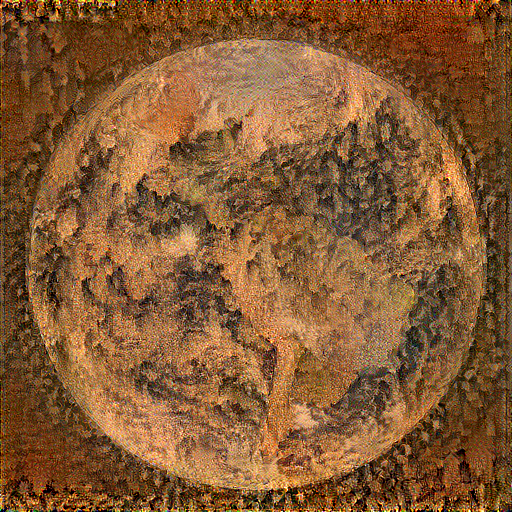

훈련 스텝: 1000
전체 소요 시간: 4053.4


In [65]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [66]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

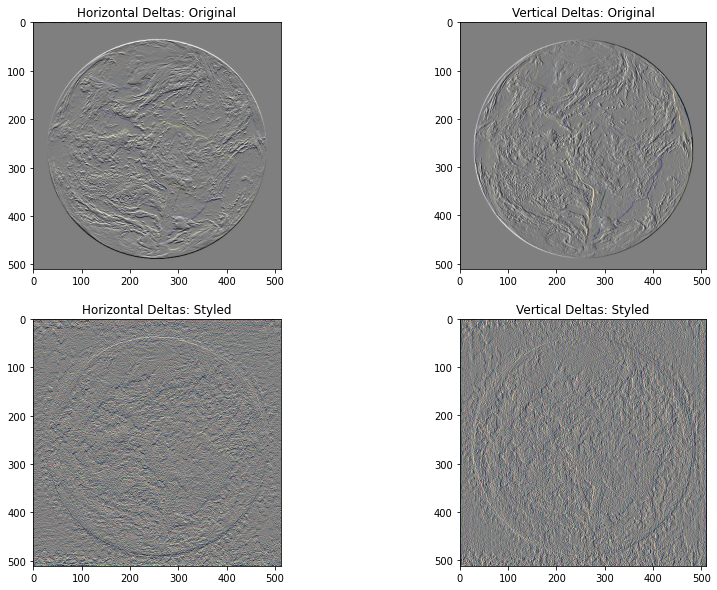

In [67]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [68]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [69]:
total_variation_loss(image).numpy()

167092.31

In [70]:
tf.image.total_variation(image).numpy()

array([167092.31], dtype=float32)

In [71]:
total_variation_weight=50

In [72]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [73]:
image = tf.Variable(content_image)

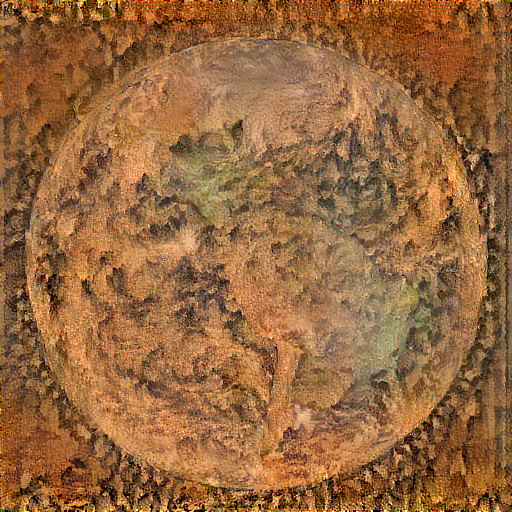

훈련 스텝: 1000
전체 소요 시간: 3368.9


In [74]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))